In [1]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
%matplotlib inline

In [2]:
#Open a digital elevation model 
grid = Grid.from_raster('../Rst/20190109125130_1063922483.tif', data_name='dem')

In [3]:
#Define a function to plot the digital elevation model 
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent)
    plt.colorbar(label=label)
    plt.grid()

In [4]:
#Minnor slicing on borders to enhance colobars
elevDem=grid.dem[:-1,:-1]

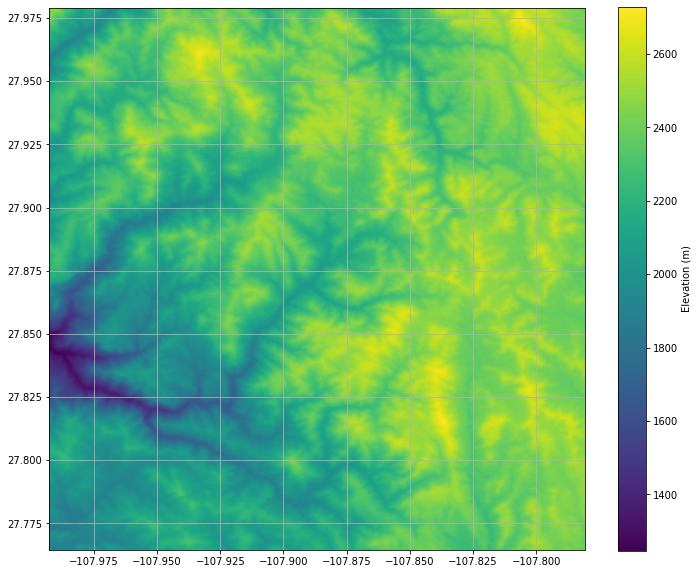

In [5]:
plotFigure(elevDem, 'Elevation (m)')

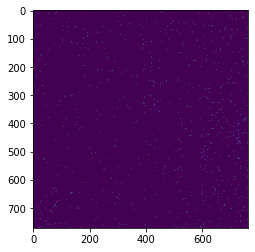

In [6]:
# Detect depressions

# Detect depressions
depressions = grid.detect_depressions('dem')

# Plot depressions
plt.imshow(depressions)

In [7]:
# Fill depressions
grid.fill_depressions(data='dem', out_name='flooded_dem')

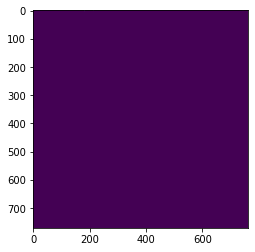

In [8]:
# Test result
depressions = grid.detect_depressions('flooded_dem')
plt.imshow(depressions)

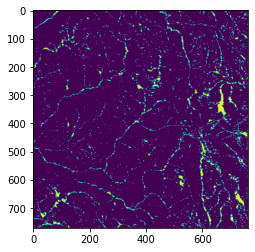

In [9]:
# Detect flats
flats = grid.detect_flats('flooded_dem')

# Plot flats
plt.imshow(flats)

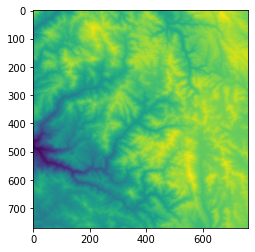

In [10]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
plt.imshow(grid.inflated_dem[:-1,:-1])

In [11]:
# Create a flow direction grid
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [12]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

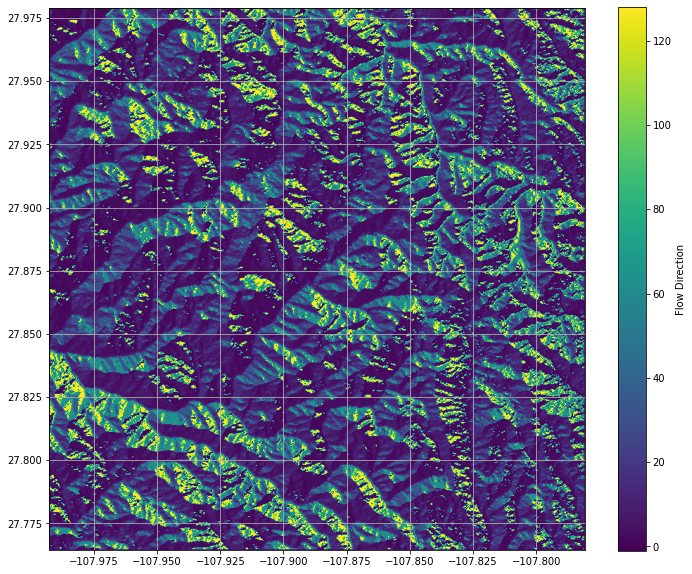

In [13]:
plotFigure(grid.dir,'Flow Direction','viridis')

In [14]:
# Specify discharge point
x, y = -107.91663,27.83479

In [15]:
# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [16]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [17]:
# Get a view of the catchment
demView = grid.view('dem', nodata=np.nan)

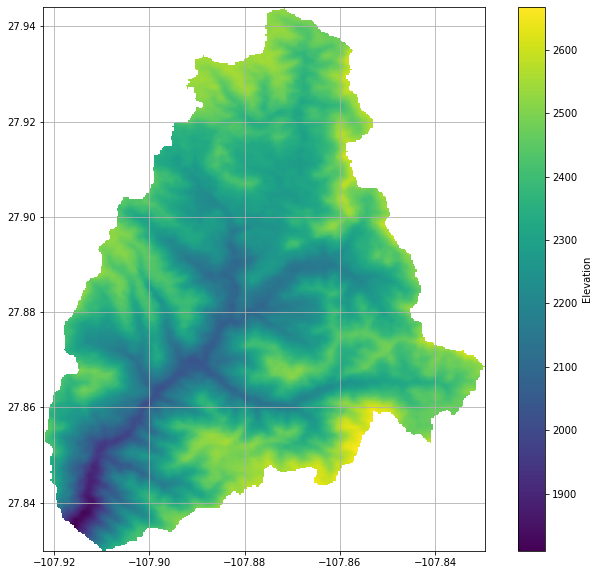

In [18]:
plotFigure(demView,'Elevation')

In [19]:
#export selected raster
grid.to_raster(demView, '../Output/clippedElevations_WGS84.tif')

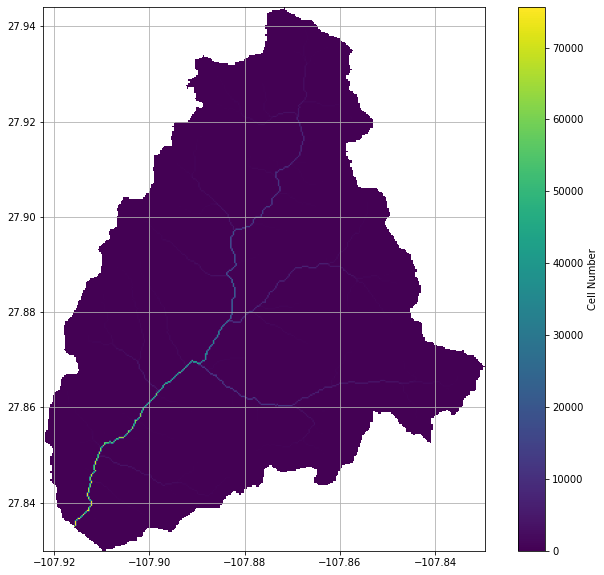

In [20]:
# Define the stream network

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

In [21]:
streams = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
streams["features"][:2]

[{"geometry": {"coordinates": [[-107.867639, 27.933194], [-107.867639, 27.933472], [-107.867639, 27.93375], [-107.867917, 27.934028], [-107.867917, 27.934306], [-107.867917, 27.934583], [-107.867917, 27.934861], [-107.867917, 27.935139], [-107.867917, 27.935417], [-107.867917, 27.935694], [-107.867917, 27.935972], [-107.867639, 27.93625], [-107.867639, 27.936528], [-107.867361, 27.936806], [-107.867361, 27.937083], [-107.867083, 27.937361], [-107.867083, 27.937639], [-107.867083, 27.937917], [-107.867083, 27.938194], [-107.867361, 27.938472], [-107.867361, 27.93875], [-107.867639, 27.939028], [-107.867639, 27.939306], [-107.867917, 27.939583], [-107.868194, 27.939583], [-107.868472, 27.939583], [-107.86875, 27.939583], [-107.869028, 27.939583], [-107.869306, 27.939861], [-107.869583, 27.940139], [-107.869861, 27.940417], [-107.870139, 27.940694], [-107.870417, 27.940694], [-107.870694, 27.940972], [-107.870972, 27.94125], [-107.87125, 27.94125], [-107.871528, 27.941528], [-107.871806, 

In [23]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [24]:
#save geojson as separate file
saveDict(streams,'../Output/streams_WGS84.geojson')

In [25]:
# Some functions to plot the json on jupyter notebook
streamNet = gpd.read_file('../Output/streams_WGS84.geojson')
streamNet.crs = {'init' :'epsg:4326'}

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:title={'center':'Catchment boundary (vector)'}>

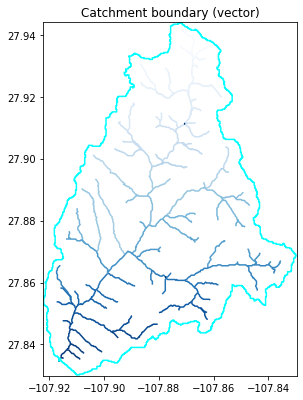

In [26]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

In [27]:
#ax = streamNet.plot()
mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')

TypeError: type object argument after ** must be a mapping, not CRS